In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from keras.layers import Input
from keras import layers, models
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import *
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import initializers
from keras.callbacks import TensorBoard





Using TensorFlow backend.


In [2]:
# !which python

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
filePath = "img_align_celeba/"
inputData = os.listdir(filePath)

img_shape     = (32, 32, 3)

def DiscDatagen(batchSize,filesList):
    while(True):
        files = np.random.choice(filesList,batchSize,replace=False)
        X_train = []
        for file in files:
            image = load_img(filePath + "/" + file,
                             target_size=img_shape[:2])
            image = img_to_array(image)/255.0
            X_train.append(image)
        X_train = np.array(X_train)
        yield X_train


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import os
from keras.layers import Input
from keras import layers, models
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import cv2

In [6]:
optimizer_gen = Adam(0.00007, 0.5)
optimizer_adv = Adam(0.00007, 0.5)
img_shape     = (32, 32, 3)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer_gen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 32)        8192      
__________

In [7]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer_adv,
                      metrics   = ['accuracy'])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0         
__________

In [8]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer_gen)
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         8584515   
_________________________________________________________________
model_2 (Model)              (None, 1)                 6711585   
Total params: 15,296,100
Trainable params: 8,584,515
Non-trainable params: 6,711,585
_________________________________________________________________


In [9]:
def plot_generated_images(imgs,noise,path_save=None,titleadd=""):
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,10,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

In [10]:
batchSize = 10

In [11]:
writer = tf.summary.FileWriter("log/run1")

In [12]:
# Create the TensorBoard callback,
# which we will drive manually
tensorboard = TensorBoard(
  log_dir='log/run2',
  histogram_freq=0,
  batch_size=batchSize,
  write_graph=True,
  write_grads=True
)
tensorboard.set_model(combined)

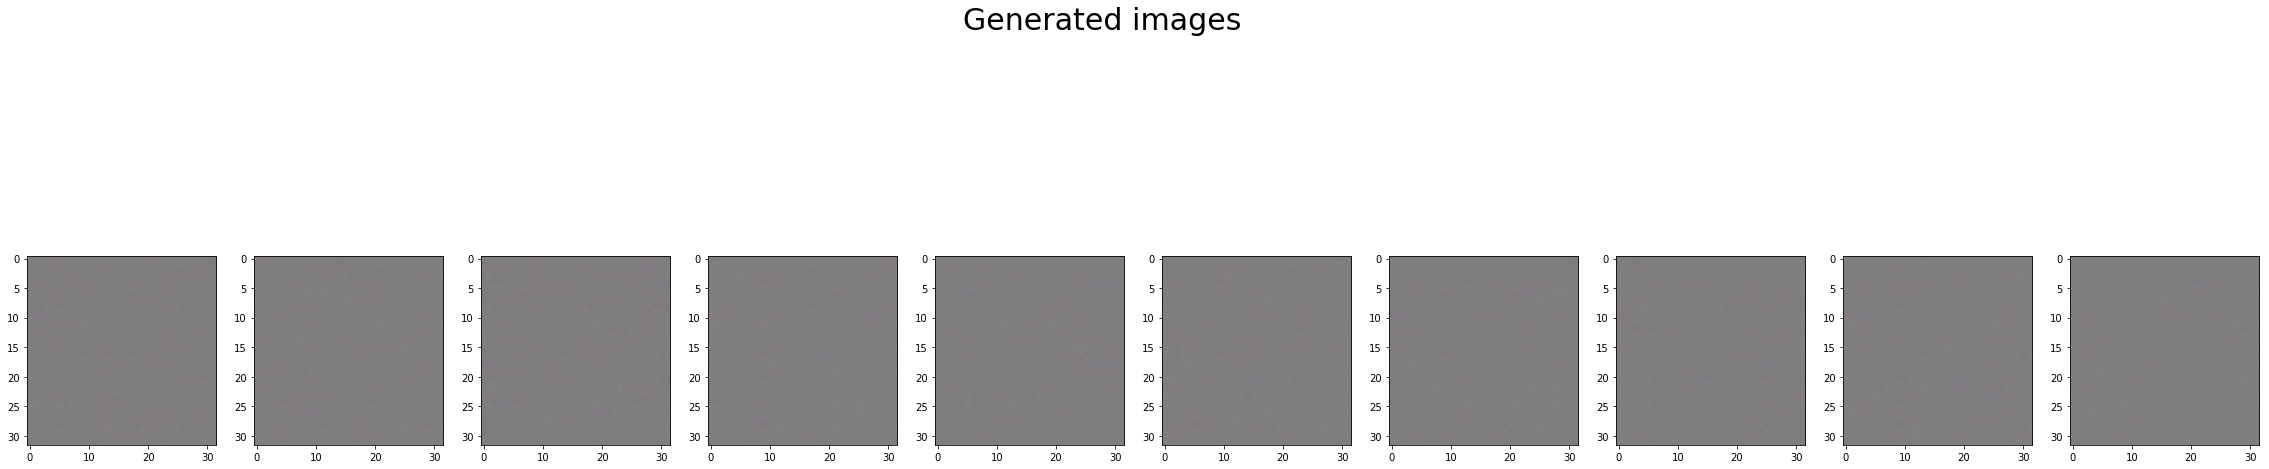

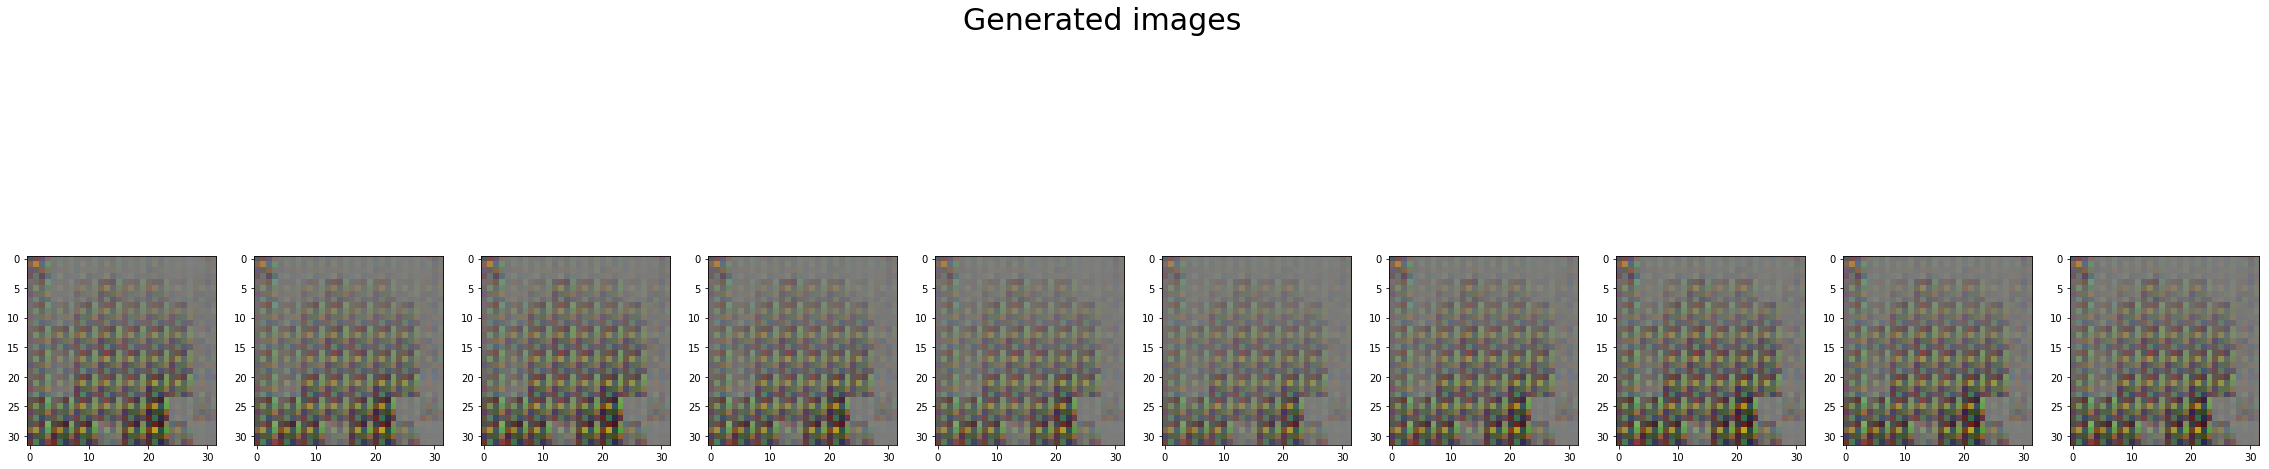

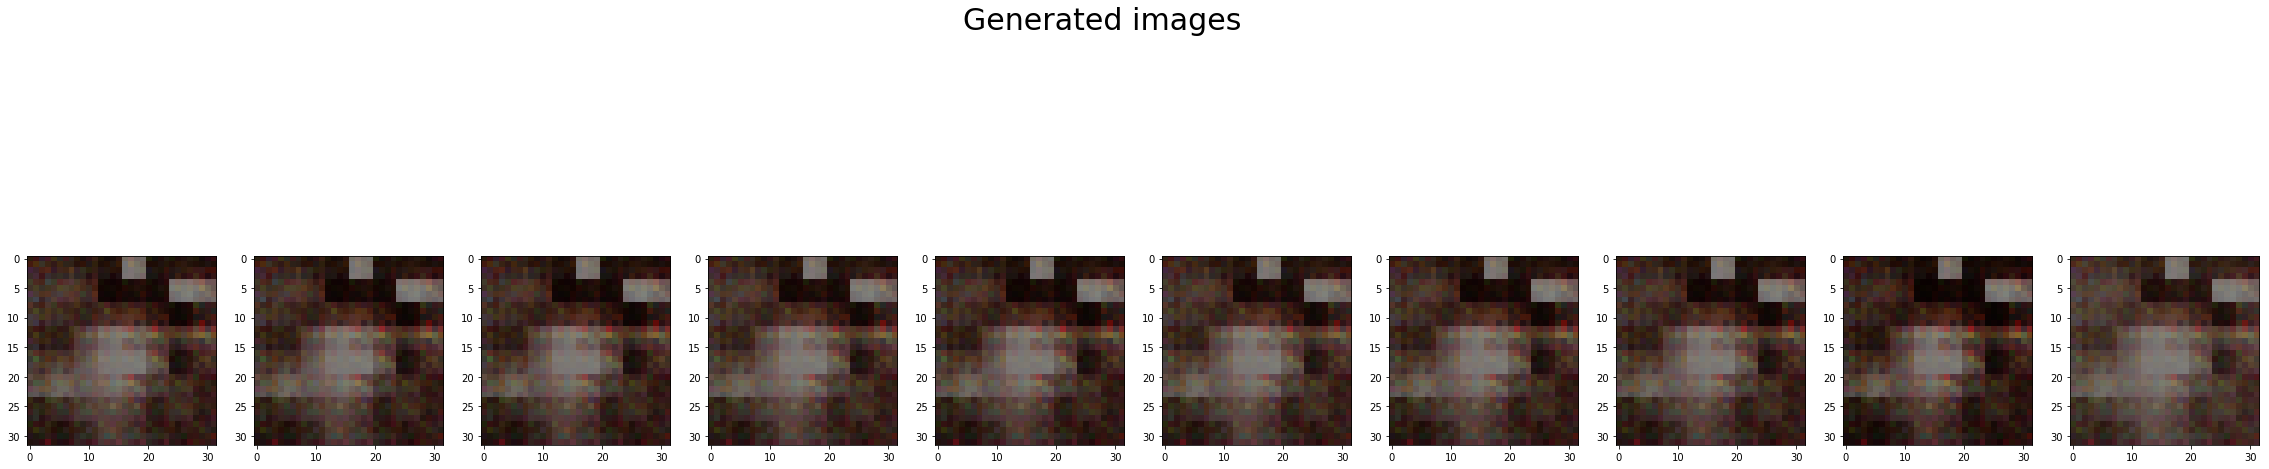

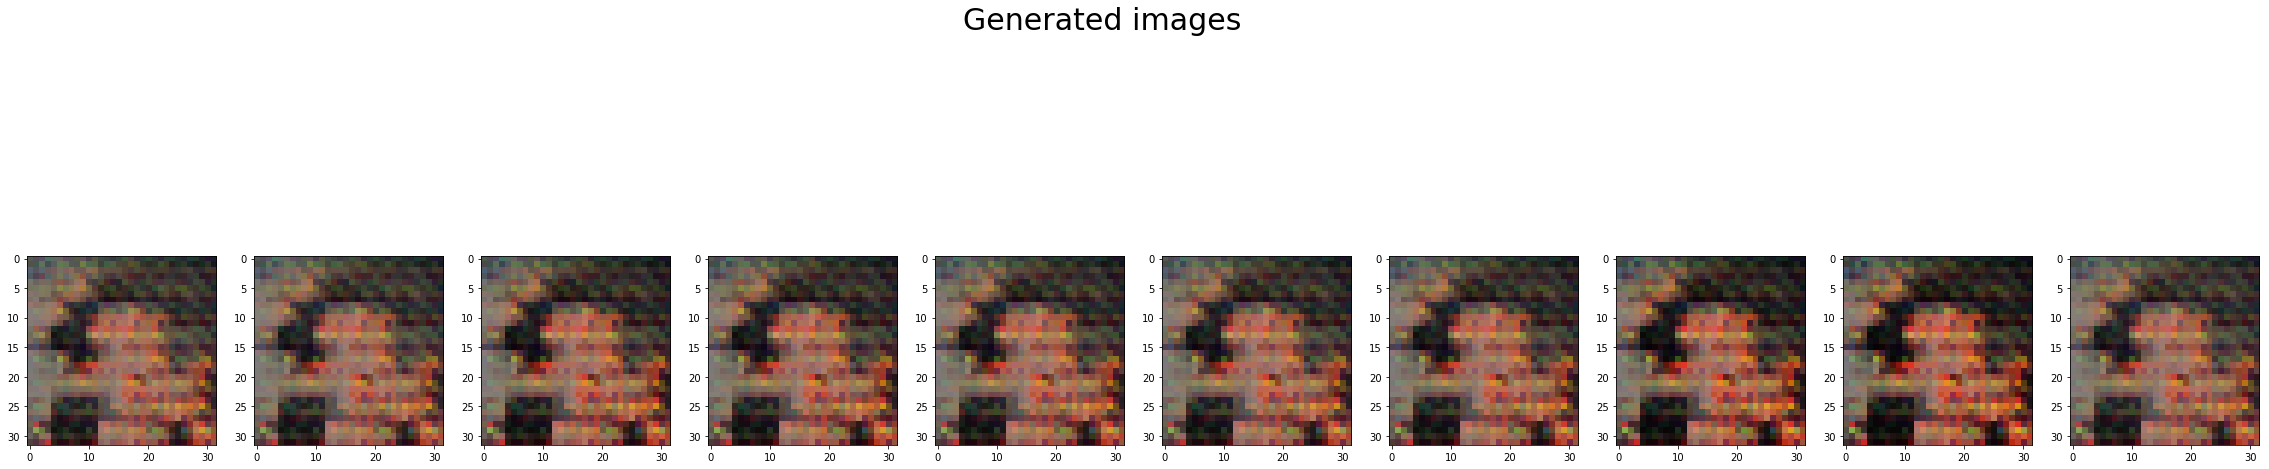

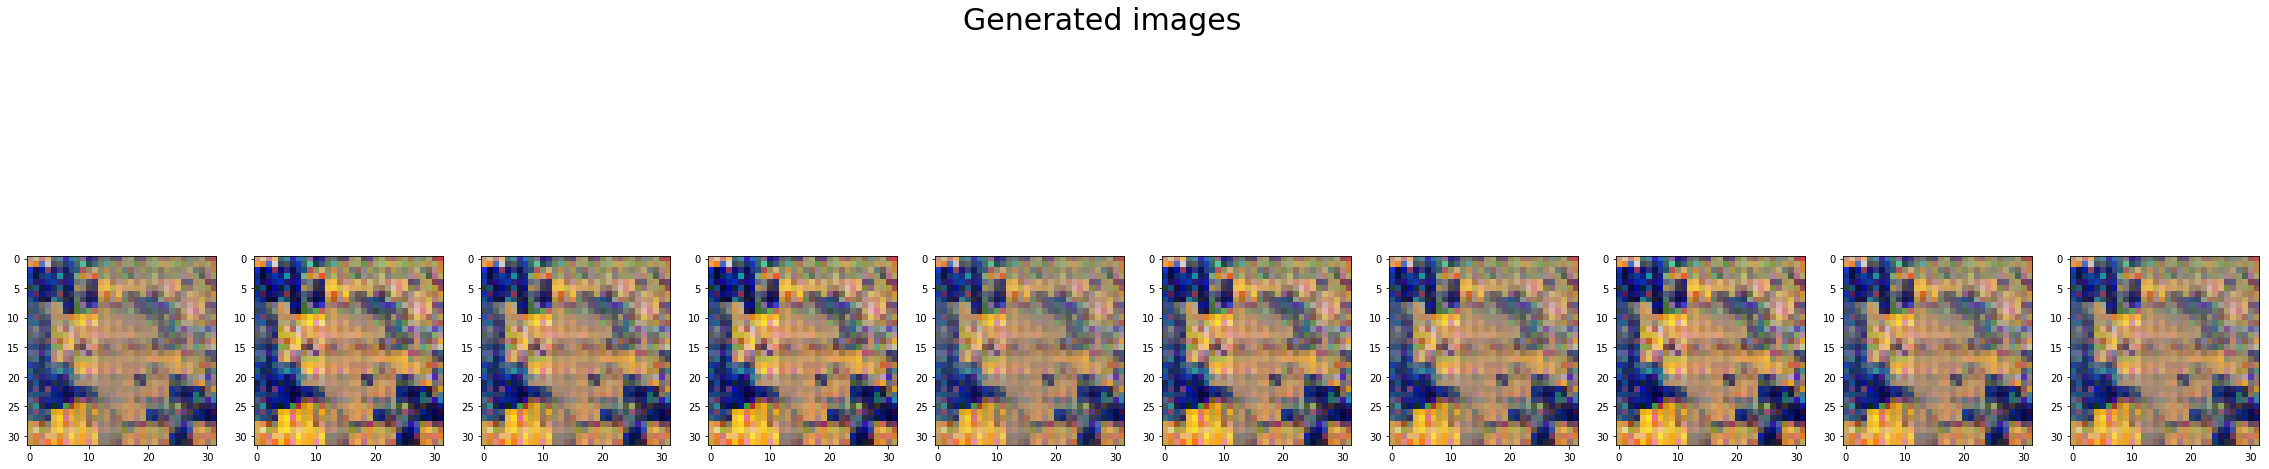

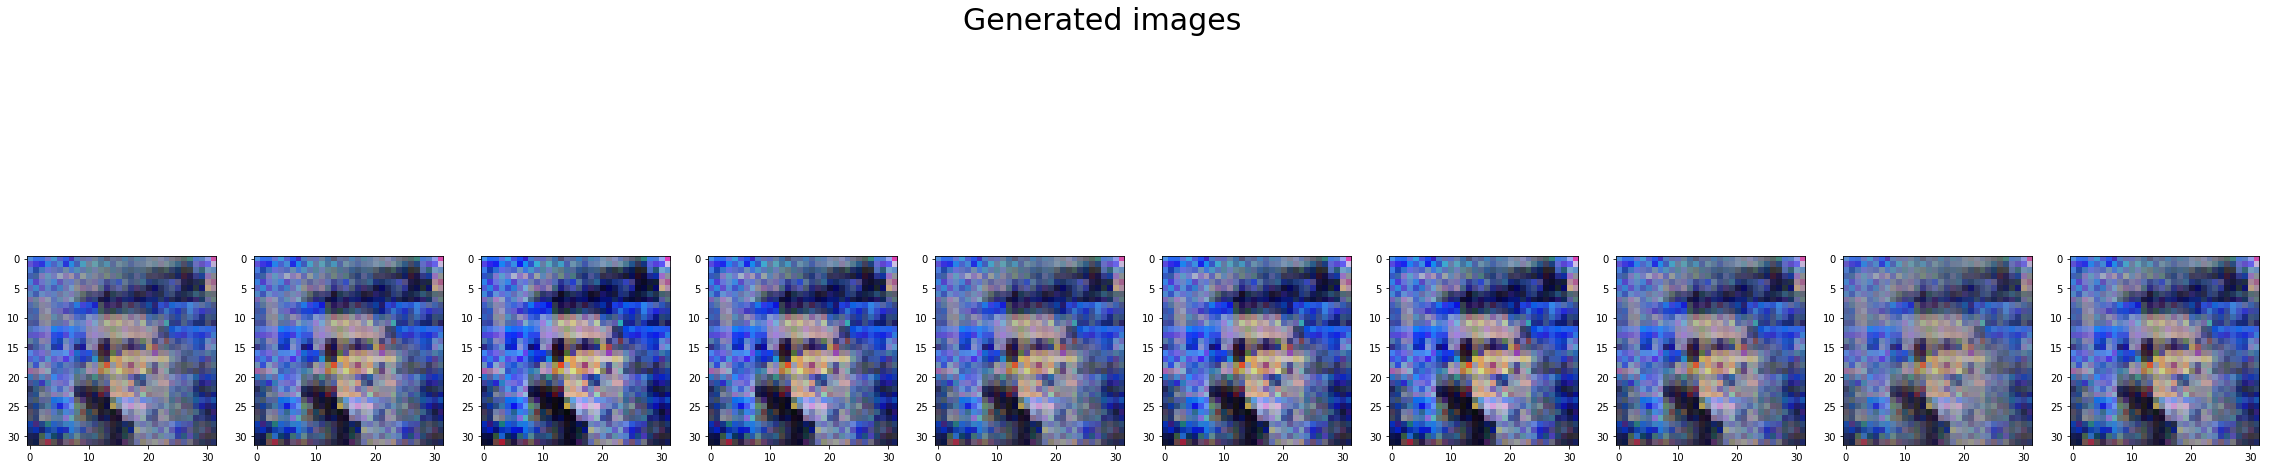

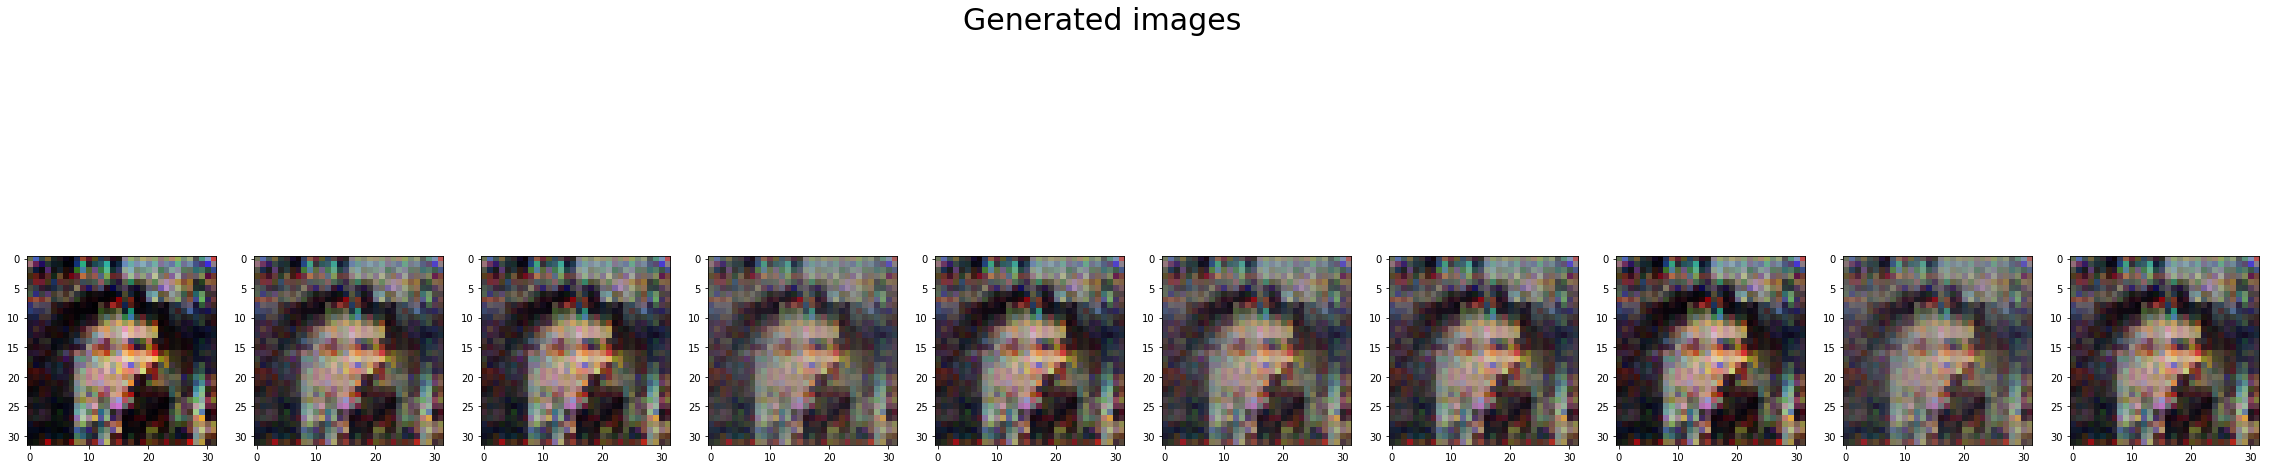

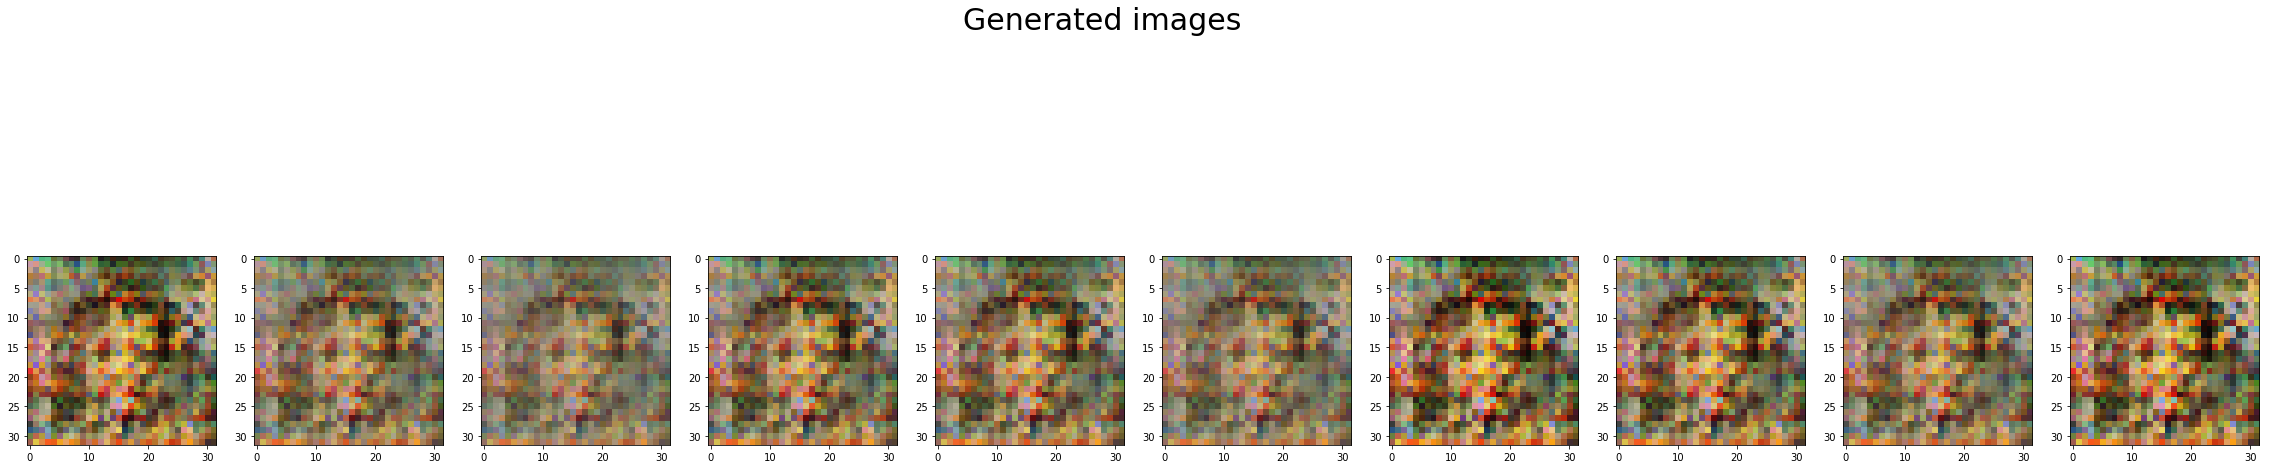

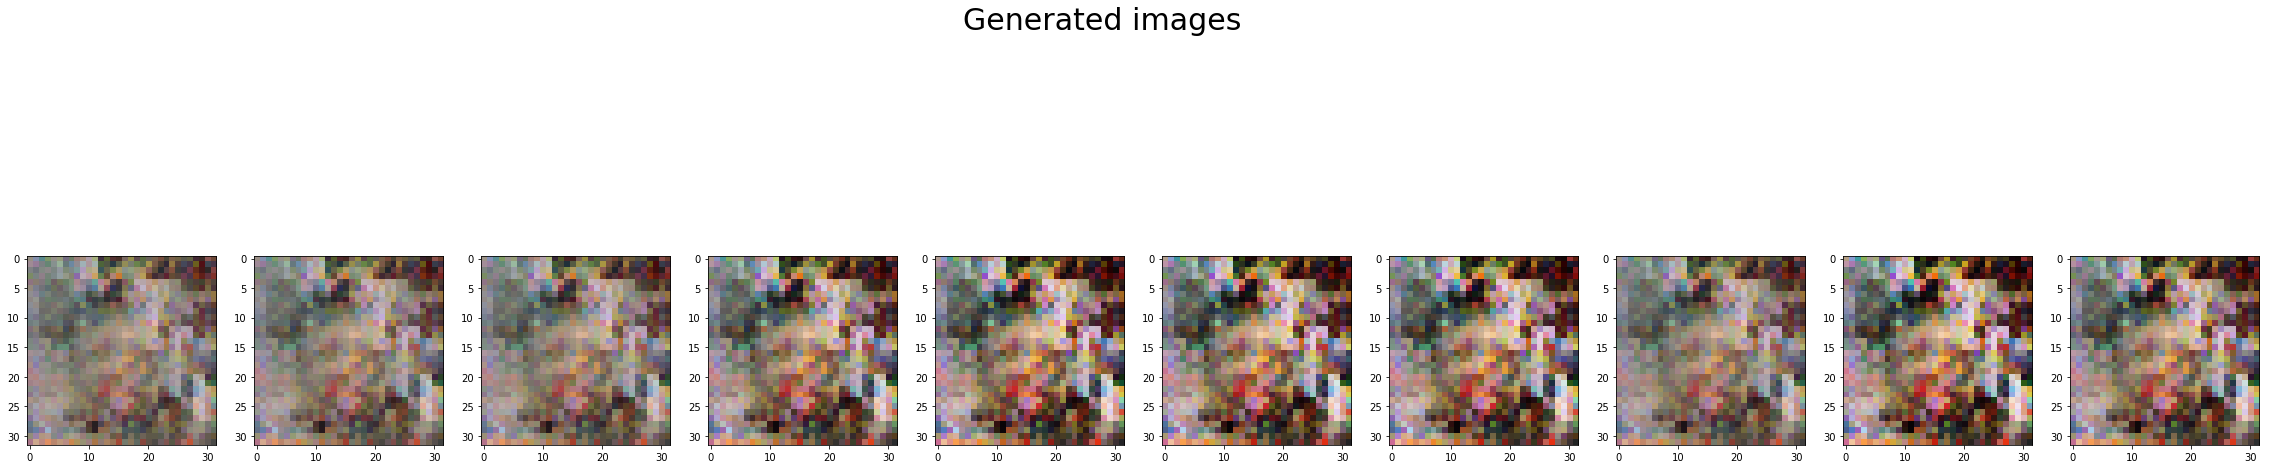

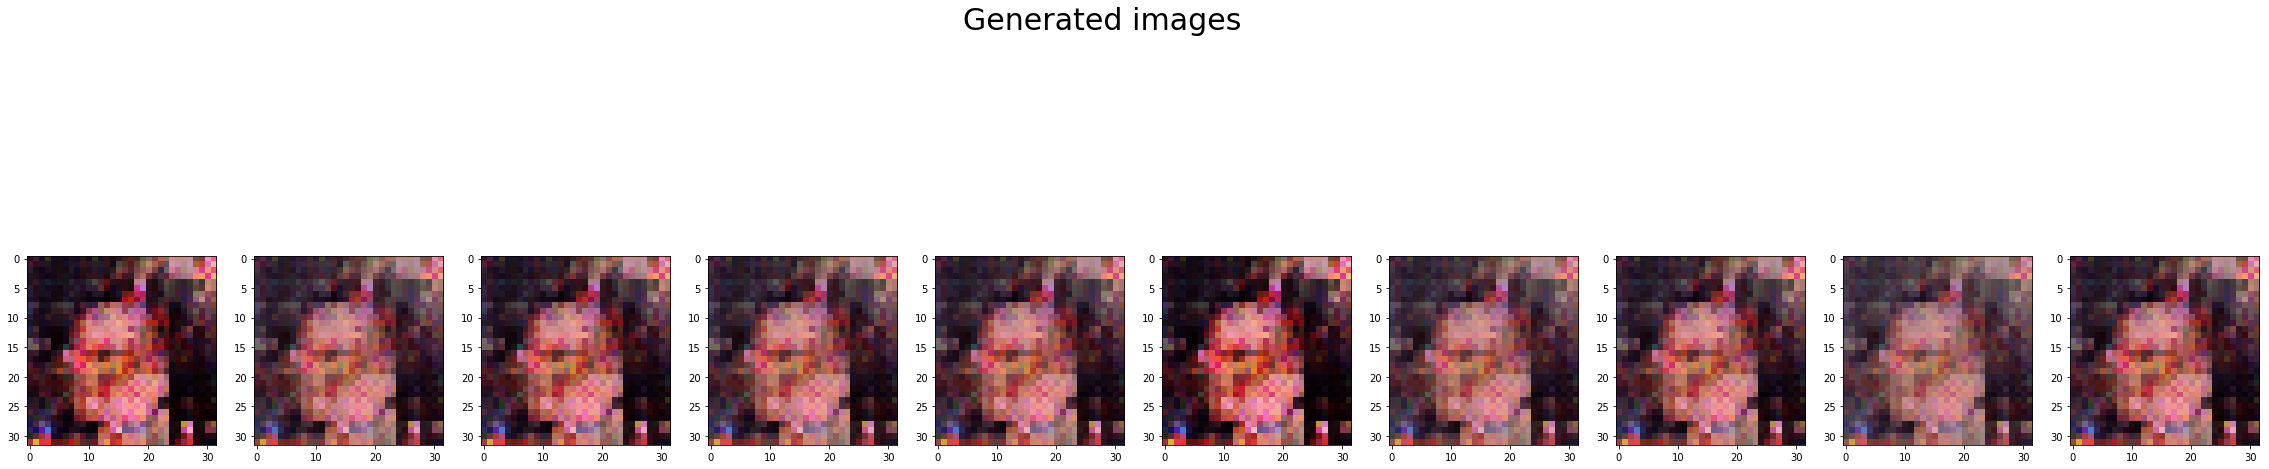

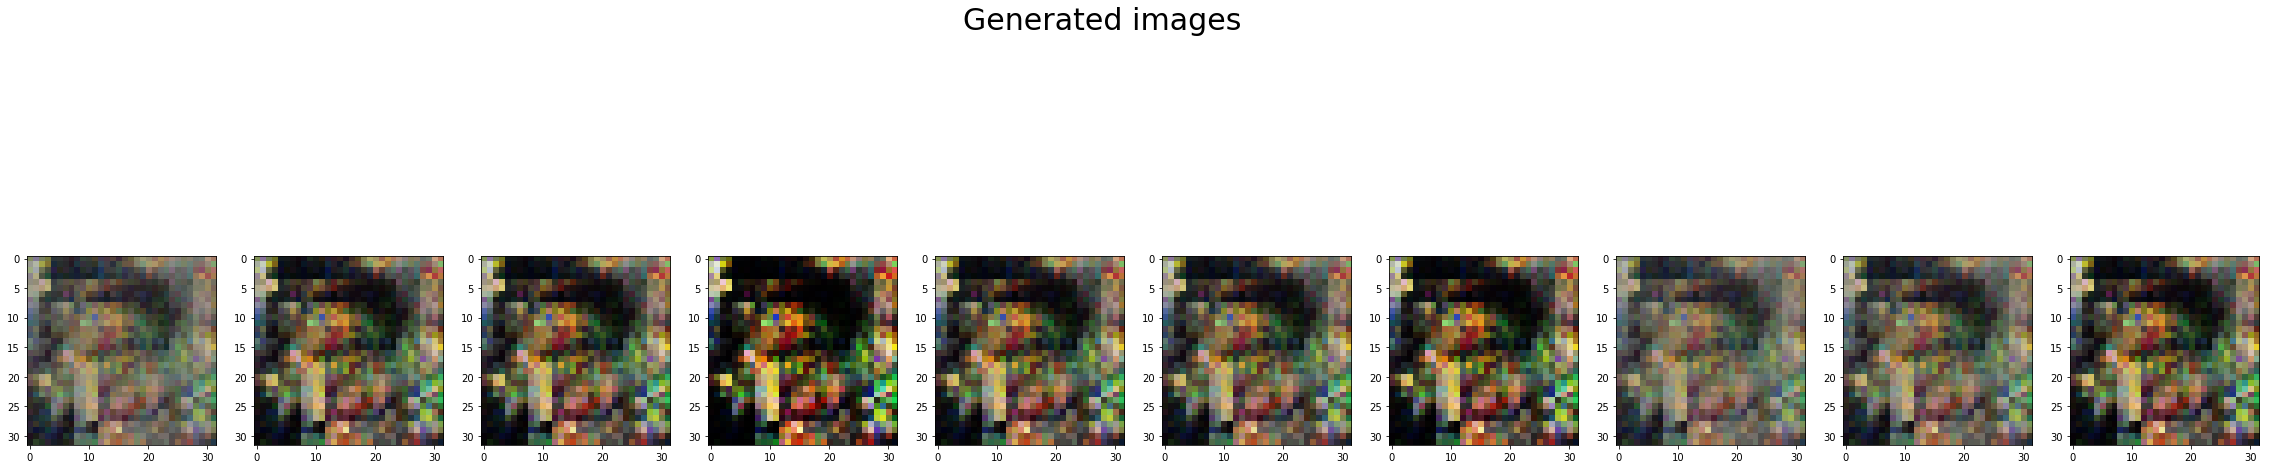

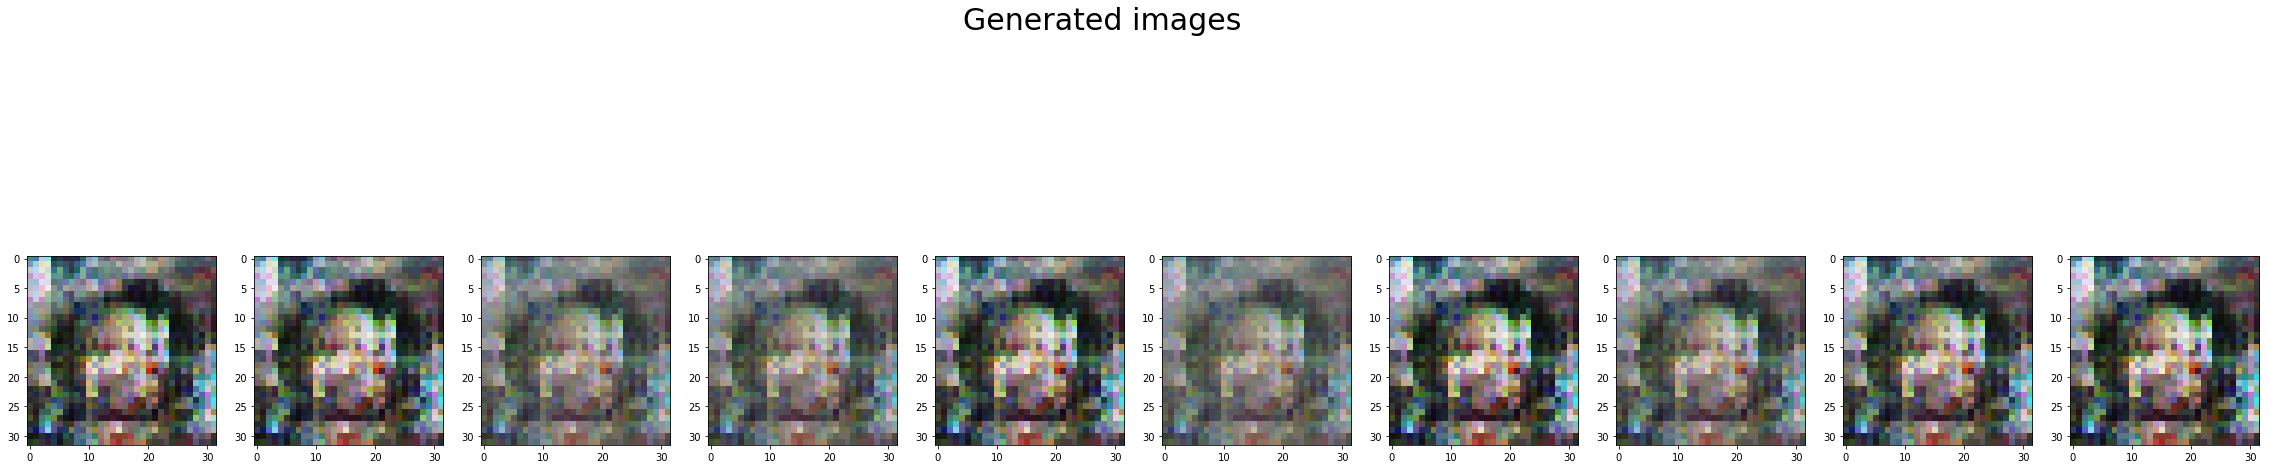

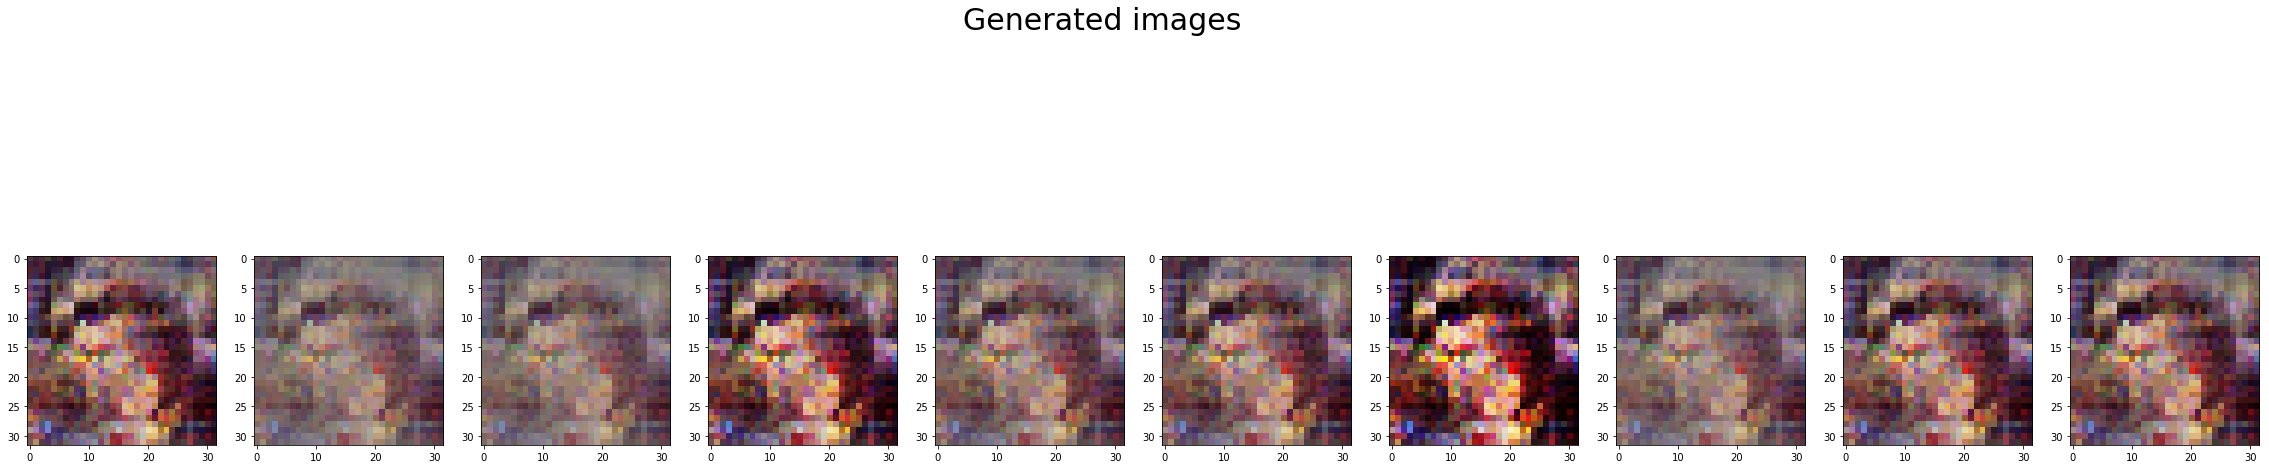

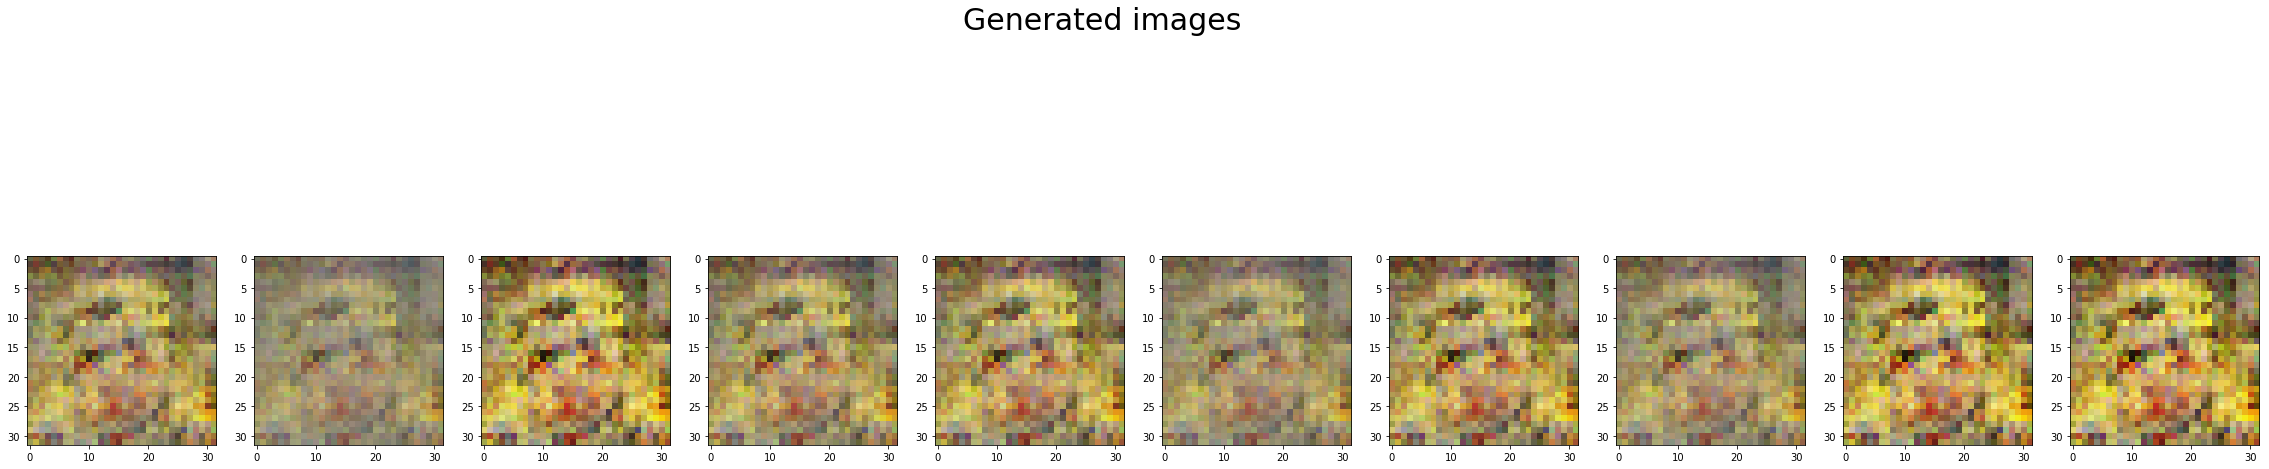

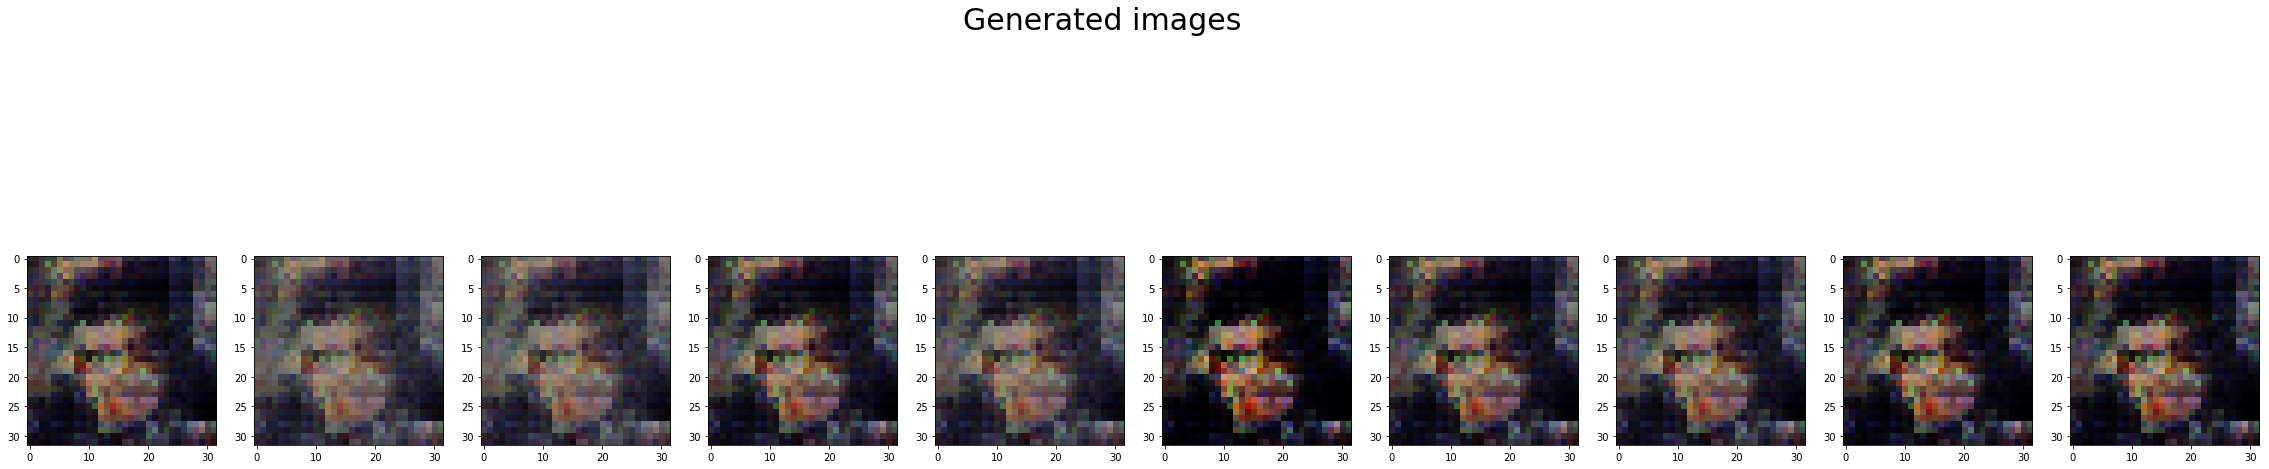

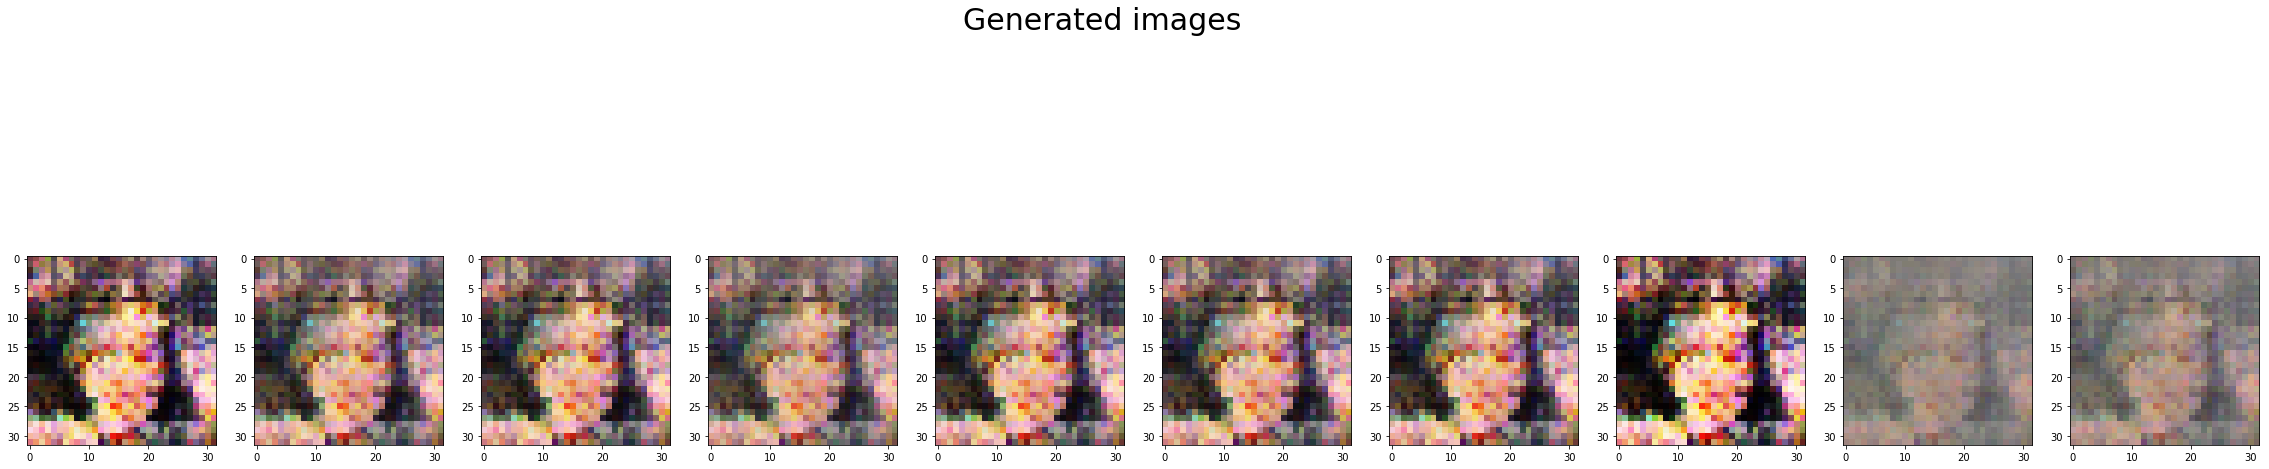

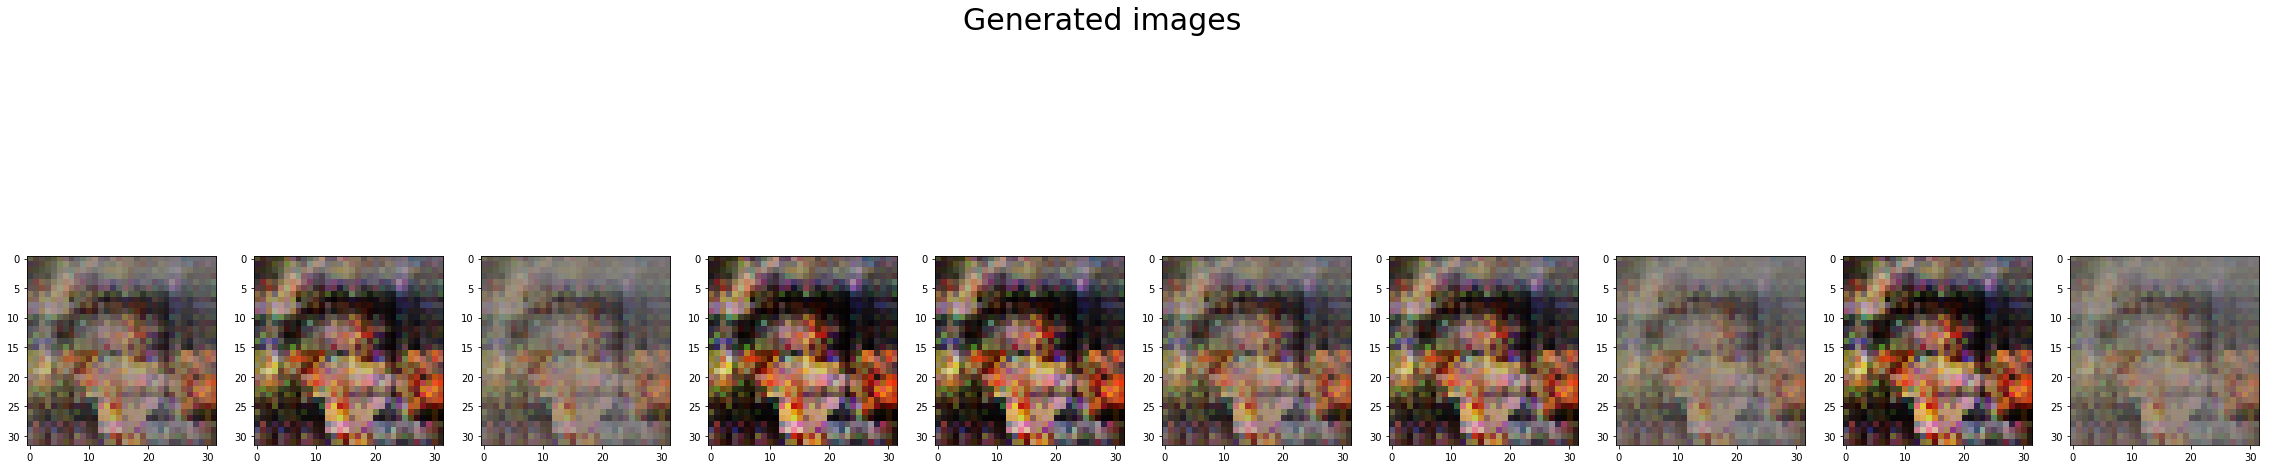

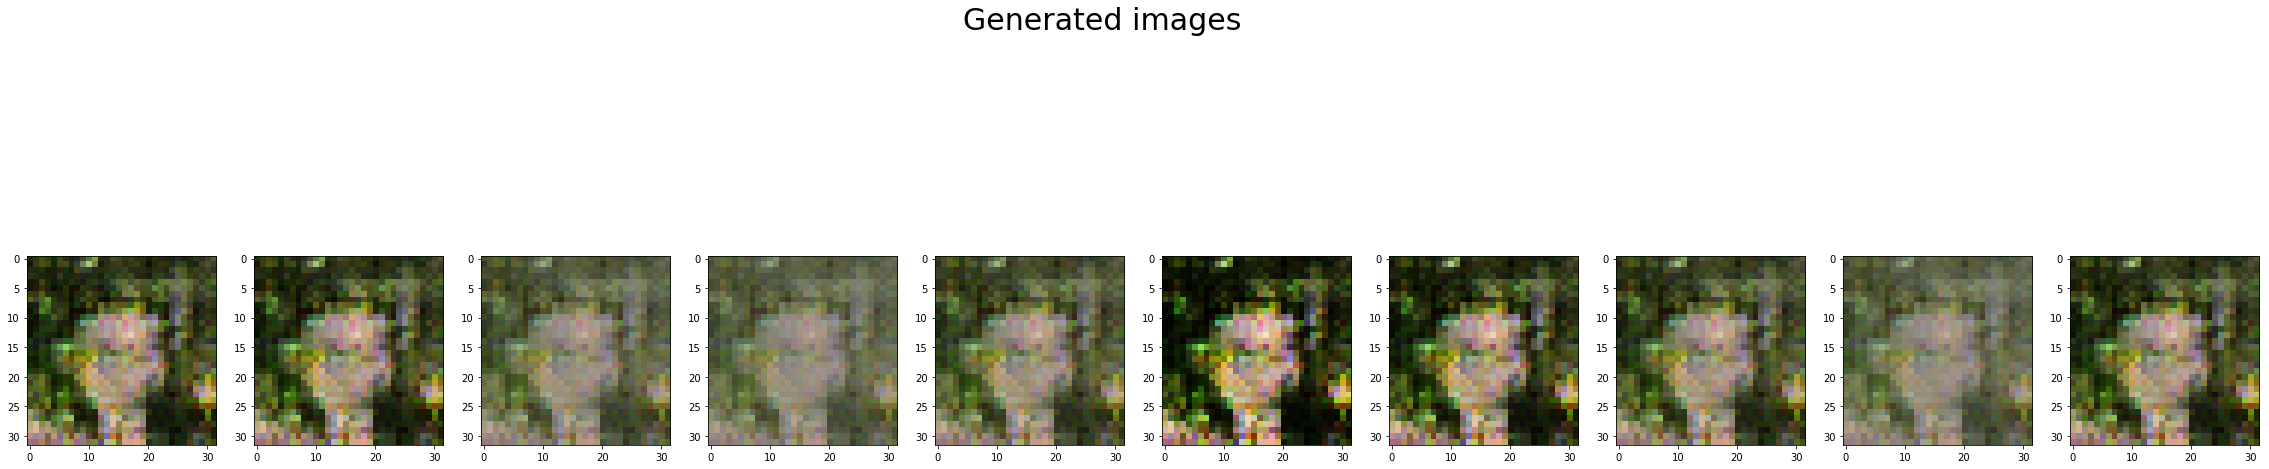

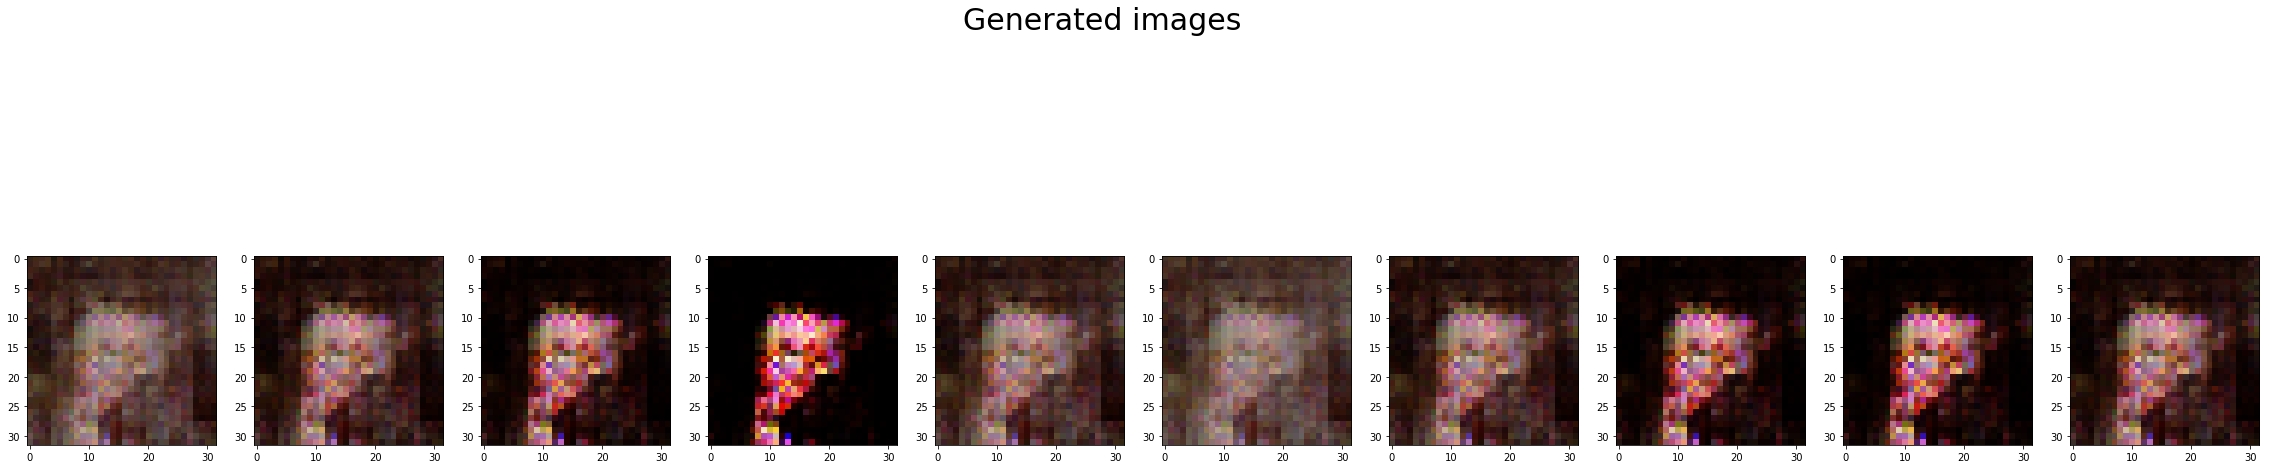

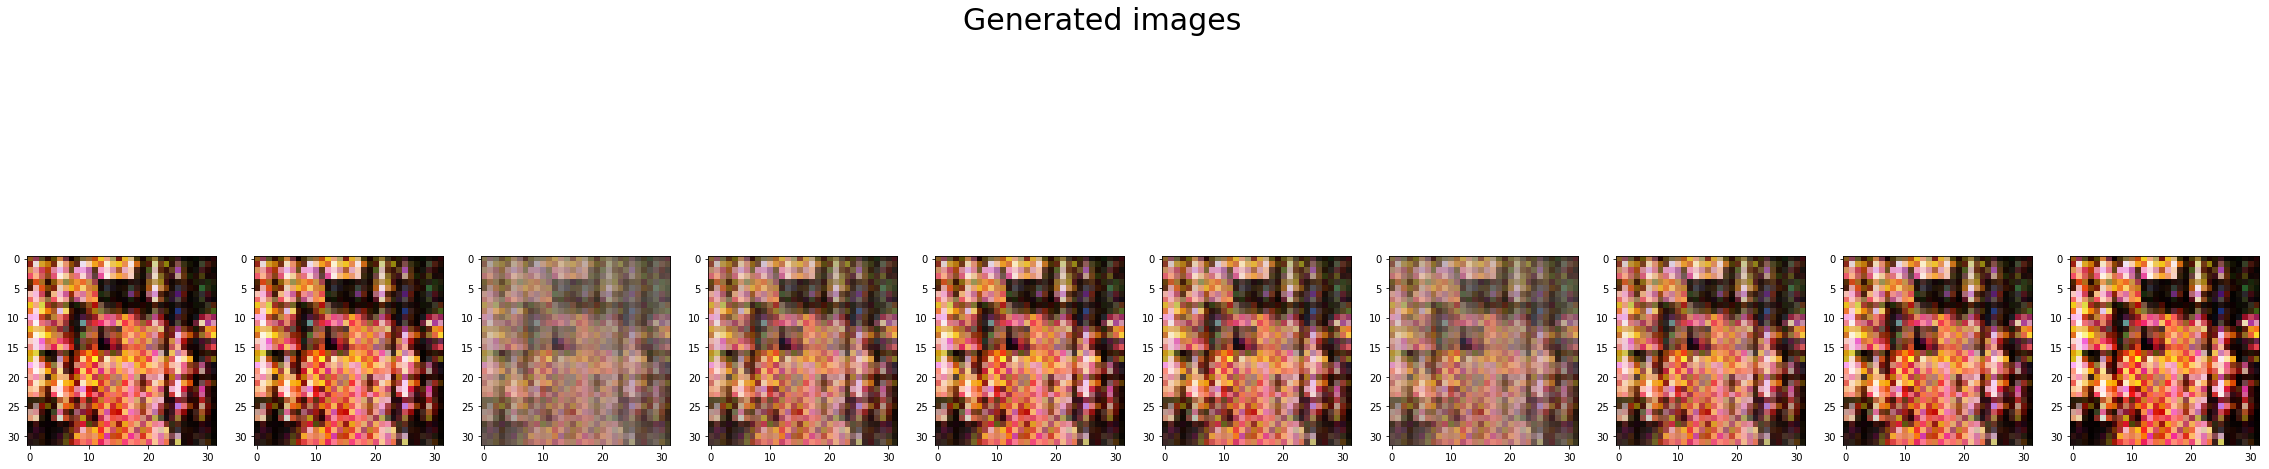

In [13]:
def train(models,inputData,epochs=2000, batchSize=10):
    combined, discriminator, generator = models
    #nlatent_dim = noise_plot.shape[1]
    #half_batch  = int(batchSize / 2)
    history = []
    datagenObj = DiscDatagen(batchSize,inputData)
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        X_train = next(datagenObj)
        idx = np.random.randint(0, X_train.shape[0], batchSize)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, size=[batchSize, 100])
        #print(noise.shape)

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)
        
        if(epoch%100==0):
            plot_generated_images(gen_imgs,noise)

        # Train the discriminator q: better to mix them together?
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((batchSize, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batchSize, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator.trainable = False


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, size=[batchSize, 100])

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = (np.array([1] * batchSize)).reshape(batchSize,1)
        yGen = np.ones(batchSize)
        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        history.append({"D":d_loss[0],"G":g_loss})
        tensorboard.on_epoch_end(epoch, {"D":d_loss[0],"G":g_loss})
        #print(history)
    tensorboard.on_train_end(None)    
    return history
      
models = combined, discriminator, generator
history = train(models,inputData)